In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format

In [2]:
## read data from csv
dfRaw = pd.read_csv("dataset.csv",index_col='DriverId')
dfRaw['ts']= pd.to_datetime(dfRaw.ts)
dfRaw

,EventName,Latitude,Longitude,Speed km/h,ts
DriverId,,,,,
0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090
...,...,...,...,...,...
88,Timed Event,34.8839,-117.8878,8.0000,2017-11-16 21:27:35.010
88,Engine turned off,34.8830,-117.8878,0.0000,2017-11-16 21:28:05.280
88,Engine started,34.8867,-117.8866,0.0000,2017-11-16 22:08:57.880


Number of drivers: 89
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
          NumEvents
DriverId           
0             17345
1             20694
2             11945
3               819
4              6811
5             24152
6              5700
7             12693
8             19606
9              3928


Text(0, 0.5, 'Number of drivers')

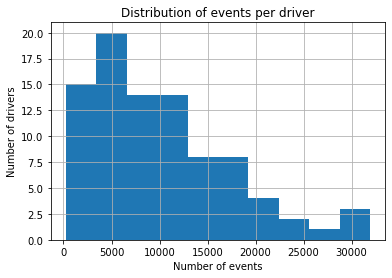

In [3]:
Driver_Index=np.unique(dfRaw.index.to_numpy())
print("Number of drivers: {}".format(len(Driver_Index)))
print(Driver_Index.view())
dfEventPerDriver=pd.DataFrame(dfRaw.groupby("DriverId").size(),columns=['NumEvents'])
print(dfEventPerDriver.head(10))
#Distribution of events per driver 
dfEventPerDriver.sort_values(by='NumEvents',ascending = False,inplace = True)
eventsHist = dfEventPerDriver['NumEvents'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

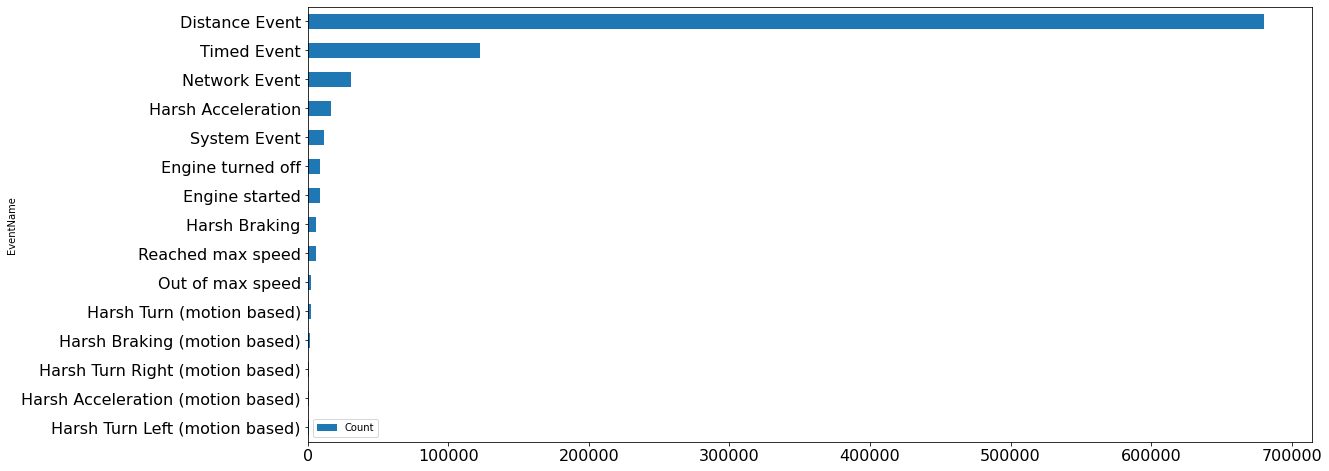

In [4]:
Event_Hist=pd.DataFrame(dfRaw.groupby(['EventName']).size(),columns=["Count"]).sort_values(by='Count', ascending=True)

Event_Hist.plot.barh(figsize=(18,8),fontsize = 16)

In [5]:
RELEVANT_EVENTS = [
        'Harsh Braking (motion based)'  , 'Harsh Acceleration (motion based)',
        'Harsh Turn Left (motion based)','Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
    
    #Remove NAs
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    ## Filter out unwanted events
    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    ## Filter out users with too few samples
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    return(df)

df = prepData(dfRaw)


*** Starting data prep. Length: 899611 ***
Removed NAs. Length: 899611
Keeping only events that are relevant for modeling. Length: 4304
Filtering users with too few samples. Length: 3443


Text(0, 0.5, 'Number of drivers')

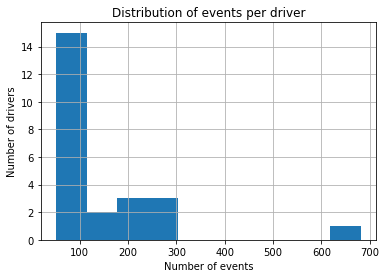

In [6]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

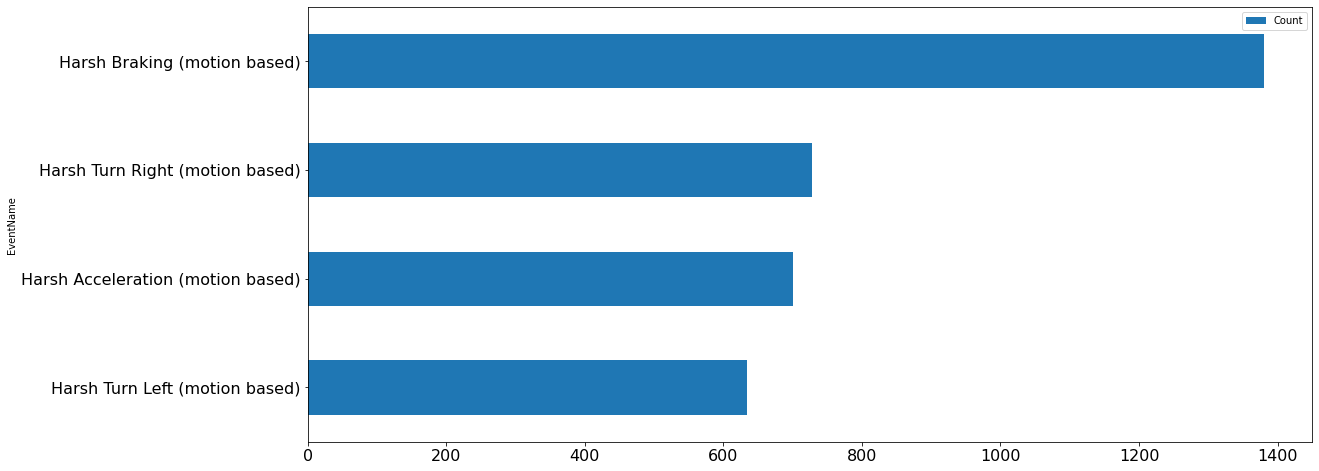

In [7]:
Event_Hist=pd.DataFrame(df.groupby(['EventName']).size(),columns=["Count"]).sort_values(by='Count', ascending=True)

Event_Hist.plot.barh(figsize=(18,8),fontsize = 16)

In [8]:
def total_time(oneDriver):
    return (oneDriver["ts"].values[-1]-oneDriver["ts"].values[0])/np.timedelta64(1, 'm')

## Calculate the overall distance made by each driver
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_time).reset_index(name='time')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver

,DriverId,time
0,0,25399.7132
1,1,25365.0170
2,2,25376.5918
3,3,25398.3647
4,4,25349.6737
...,...,...
84,84,25346.5500
85,85,25352.8150
86,86,25307.7133
87,87,25326.6463


## Feature engineering


,Harsh Acceleration,Harsh Braking,Harsh Turn Left,Harsh Turn Right
DriverId,,,,
0,0.0000,0.0018,0.0010,0.0006
4,0.0000,0.0011,0.0015,0.0004
5,0.0002,0.0010,0.0007,0.0019
6,0.0000,0.0007,0.0012,0.0003
8,0.0013,0.0022,0.0020,0.0018


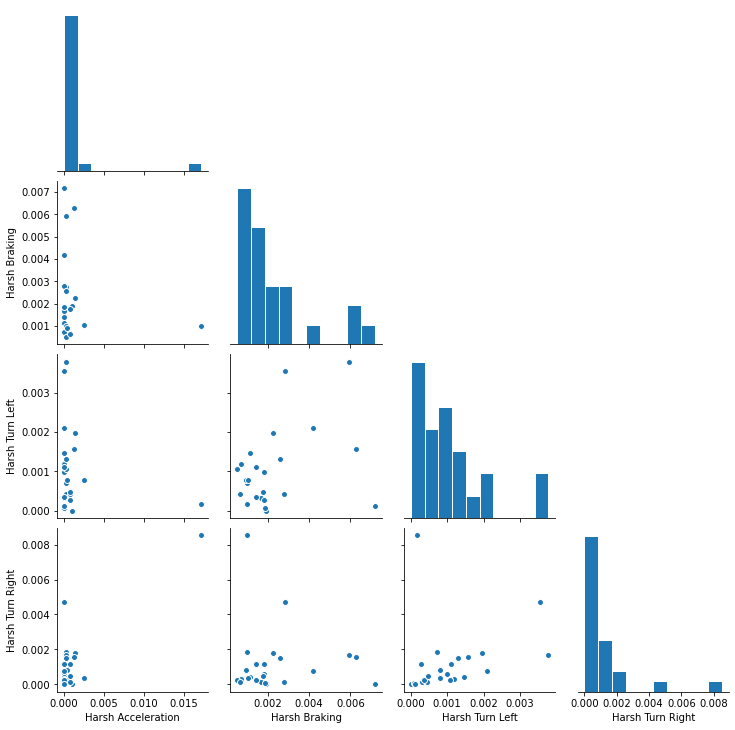

In [9]:
## Transform the events data frame to a features data frame (column for each type of relevant event)
def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName']).size().to_frame().rename(columns={0:"count"}).reset_index()

    ## Pivot events into columns
    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['time'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)

features = features.rename(columns={'F_Harsh Acceleration (motion based)': "Harsh Acceleration",
                                    'F_Harsh Braking (motion based)': "Harsh Braking",
                                    'F_Harsh Turn Left (motion based)':"Harsh Turn Left",
                                    'F_Harsh Turn Right (motion based)':"Harsh Turn Right"                                    
                                   },copy =False)
#plots of the detail of these features
g = sns.PairGrid(features,diag_sharey=False, corner=True)
g = g.map_lower(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

features.head()

,Harsh Acceleration,Harsh Braking,Harsh Turn Left,Harsh Turn Right
DriverId,,,,
0,0.0000,0.0008,0.0007,0.0005
4,0.0000,0.0004,0.0009,0.0004
5,0.0002,0.0003,0.0006,0.0011
6,0.0000,0.0001,0.0008,0.0003
8,0.0010,0.0009,0.0011,0.0011
14,0.0000,0.0007,0.0003,0.0001
15,0.0003,0.0003,0.0006,0.0006
17,0.0014,0.0004,0.0006,0.0003
18,0.0006,0.0008,0.0003,0.0008


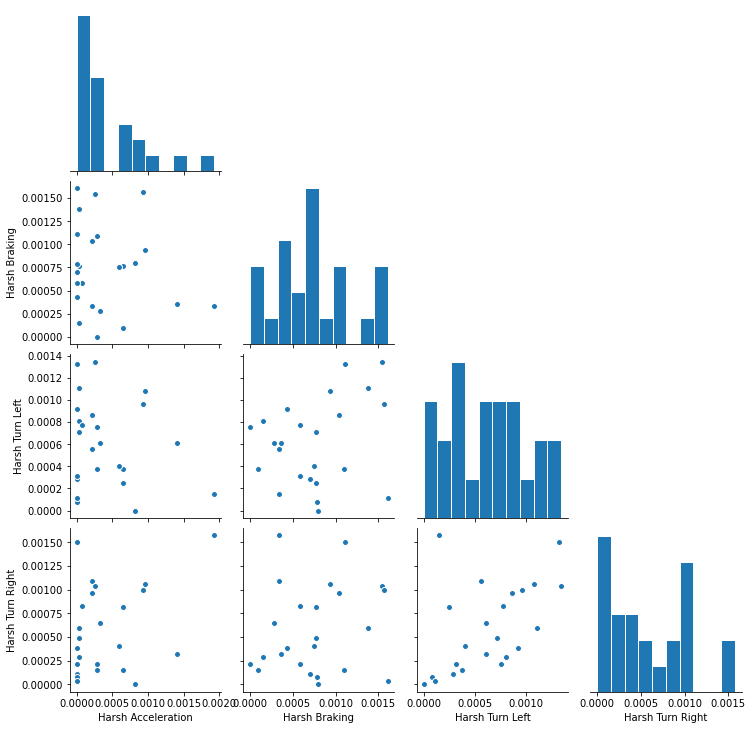

In [10]:
import scipy.stats as st
def transform_to_normal(x):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    xt = xt - np.min(xt)
    return xt

transFeatures = features.apply(transform_to_normal)
#plots of the detail of these features
g = sns.PairGrid(transFeatures,diag_sharey=False, corner=True)
g = g.map_lower(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

transFeatures.head(10)

found outlier with factor: 2 : [ 7 15]
replacing outliers [ 7 15] with max=0.001339194945846764
found outlier with factor: 2 : [ 7 15]
replacing outliers [ 7 15] with max=0.001339194945846764
found outlier with factor: 2 : [15 18]
replacing outliers [15 18] with max=0.0018519625585445918


,Harsh Acceleration,Harsh Braking,Harsh Turn Left,Harsh Turn Right
DriverId,,,,
0,0.0000,0.0018,0.0010,0.0006
4,0.0000,0.0011,0.0015,0.0004
5,0.0002,0.0010,0.0007,0.0019
6,0.0000,0.0007,0.0012,0.0003
8,0.0013,0.0022,0.0020,0.0018
14,0.0000,0.0017,0.0003,0.0001
15,0.0004,0.0009,0.0008,0.0008
17,0.0025,0.0010,0.0008,0.0004
18,0.0008,0.0018,0.0003,0.0011


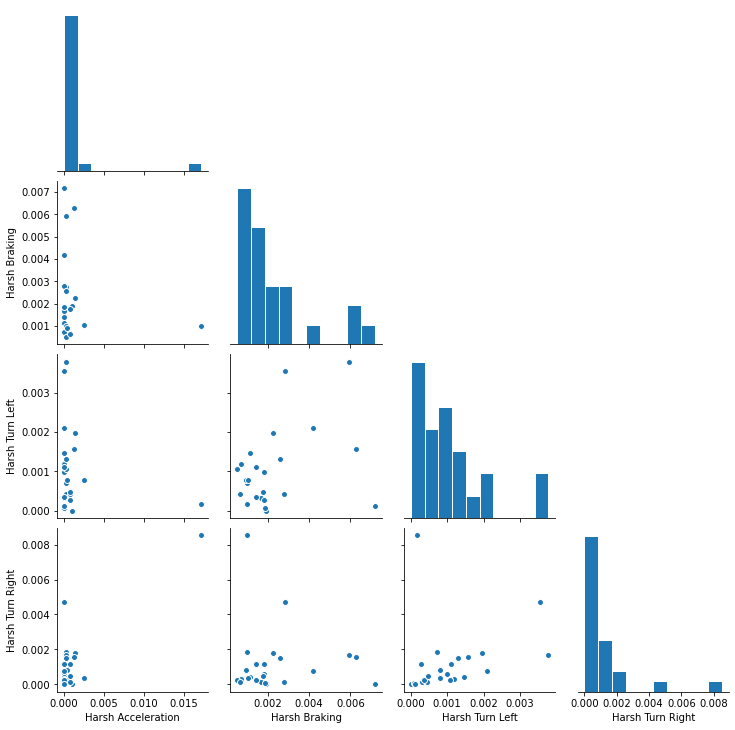

In [11]:
def replace_outliers_with_limit(x, stdFactor = 2):
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found\n")
        return x
    
    xt = transform_to_normal(x)
    
    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
    return x

cleanFeatures = features.apply(replace_outliers_with_limit)
#plots of the detail of these features
g = sns.PairGrid(cleanFeatures,diag_sharey=False, corner=True)
g = g.map_lower(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

cleanFeatures.head(10)

## Modeling
#### Main hypothesis

In [12]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())

# Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


Min and Max values per column before normalization
Harsh Acceleration range:[0.0,0.01719401847439446]
Harsh Braking range:[0.0005123160482430683,0.007180464402453194]
Harsh Turn Left range:[0.0,0.0037828312068206808]
Harsh Turn Right range:[0.0,0.008518137592819273]

Mean and STD before standardization
Harsh Acceleration range:[0.0004054880960826404,0.000503913579148462]
Harsh Braking range:[0.0007491010129388099,0.0004681530750336674]
Harsh Turn Left range:[0.0006155478192613737,0.0003897306913244492]
Harsh Turn Right range:[0.0005822271576445174,0.00046375326345143657]


###  comparing each driver to a homogeneous population

Harsh Acceleration
sse: 488.74241328968645
Harsh Braking
sse: 178.99601971444747
Harsh Turn Left
sse: 105.49323057537333
Harsh Turn Right
sse: 128.6026550892663


Text(0, 0.5, 'Number of drivers')

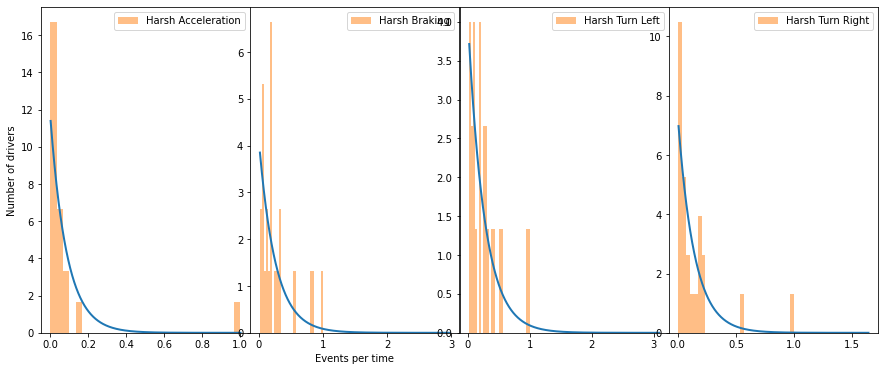

In [13]:
## Plot each fitted distribution
DIST = st.expon

def create_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## fit exponential distribution
fig, axs = plt.subplots(1,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in normalizedFeatures:
    print(col)
    feature = normalizedFeatures[col]
    x = feature.values[feature.values > 0] # only fit positive values to keep the distribution tighter
   
    params = DIST.fit(x)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   
    #Plot
    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    
    #Plot
    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    ## Calculate SSE
    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per time')
axs[0].set_ylabel('Number of drivers')

In [14]:
import scipy.stats as st


def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
  
    probs = np.zeros(len(series))
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        loc = params[0]
        scale = params[1]
        return loc, scale

def calculate_score_for_series(x, fittedParams,verbose = False):
    
    print("Calculating scores for feature: "+ x.name)
    xPositive = x[x>0]
  
    probs = np.zeros(len(x))
    if(len(xPositive)>0):
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale)
    return probs

## Store each fitted distribution parameters for later use
fittedParams = {}
for col in normalizedFeatures.columns:
    loc,scale = fit_distribution_params(normalizedFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale

import json
print('Fitted parameters:')
print(json.dumps(fittedParams, indent=2))

#Commulative distribution/density function
perFeatureScores = normalizedFeatures.apply(calculate_score_for_series,args=(fittedParams,False),axis=0).add_suffix("_CDF")

perFeatureScores.head()

Extracting distribution parameters for feature: Harsh Acceleration (24 values)
Extracting distribution parameters for feature: Harsh Braking (24 values)
Extracting distribution parameters for feature: Harsh Turn Left (24 values)
Extracting distribution parameters for feature: Harsh Turn Right (24 values)
Fitted parameters:
{
  "Harsh Acceleration": {
    "loc": 0.0022897802160888143,
    "scale": 0.08689679715560734
  },
  "Harsh Braking": {
    "loc": 0.01790673696700381,
    "scale": 0.25696979087630784
  },
  "Harsh Turn Left": {
    "loc": 0.02084287002651527,
    "scale": 0.2664772087874299
  },
  "Harsh Turn Right": {
    "loc": 0.004631658115694075,
    "scale": 0.1419147307500387
  }
}
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turn Left
Calculating scores for feature: Harsh Turn Right


,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turn Left_CDF,Harsh Turn Right_CDF
DriverId,,,,
0,0.0000,0.4975,0.5927,0.3661
4,0.0000,0.2584,0.7458,0.2784
5,0.1236,0.1863,0.4649,0.7767
6,0.0000,0.0440,0.6650,0.2038
8,0.5810,0.6100,0.8467,0.7616


In [18]:
def calculate_joint_score(perFeatureScores):
    driverMetric = perFeatureScores
    featureCols = [col for col in driverMetric if col.startswith('Harsh')]
    driverMetric['metric'] = (driverMetric[featureCols].sum(axis = 1))
    driverMetric = driverMetric.sort_values('metric')
    return driverMetric

driverMetric = calculate_joint_score(perFeatureScores)

In [20]:
driverMetric.tail(5)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turn Left_CDF,Harsh Turn Right_CDF,metric
DriverId,,,,,
51,1.0000,0.1867,0.0753,0.9991,2.2611
73,0.0000,0.7186,0.9682,0.9788,2.6657
8,0.5810,0.6100,0.8467,0.7616,2.7993
44,0.1464,0.9541,0.9746,0.7456,2.8207
49,0.5586,0.9627,0.7736,0.7196,3.0144


In [21]:
driverMetric.head(5)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turn Left_CDF,Harsh Turn Right_CDF,metric
DriverId,,,,,
63,0.0000,0.5097,0.0000,0.0321,0.5417
14,0.0000,0.4493,0.2089,0.0630,0.7212
80,0.0000,0.3693,0.2399,0.1507,0.7599
75,0.3948,0.0000,0.2972,0.0934,0.7853
6,0.0000,0.0440,0.6650,0.2038,0.9128


In [23]:
def transform_metric(driverMetric):
    driverScoresTransfered=driverMetric   
    driverScoresTransfered['score']=(4-driverMetric.metric)/4*10
    return driverScoresTransfered
driverScoresTransfered=transform_metric(driverMetric)

In [24]:
driverScoresTransfered.head(5)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turn Left_CDF,Harsh Turn Right_CDF,metric,score
DriverId,,,,,,
63,0.0000,0.5097,0.0000,0.0321,0.5417,8.6457
14,0.0000,0.4493,0.2089,0.0630,0.7212,8.1970
80,0.0000,0.3693,0.2399,0.1507,0.7599,8.1002
75,0.3948,0.0000,0.2972,0.0934,0.7853,8.0368
6,0.0000,0.0440,0.6650,0.2038,0.9128,7.7180


In [25]:
driverScoresTransfered.tail(5)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turn Left_CDF,Harsh Turn Right_CDF,metric,score
DriverId,,,,,,
51,1.0000,0.1867,0.0753,0.9991,2.2611,4.3472
73,0.0000,0.7186,0.9682,0.9788,2.6657,3.3357
8,0.5810,0.6100,0.8467,0.7616,2.7993,3.0018
44,0.1464,0.9541,0.9746,0.7456,2.8207,2.9482
49,0.5586,0.9627,0.7736,0.7196,3.0144,2.4639


In [32]:
safeDriver = [{
                'Harsh Acceleration':0.005,
                'Harsh Braking'  :0.005,
                'Harsh Turn Left':0.005,
                'Harsh Turn Right':0.005,
              }]

riskyDriver = [{
                'Harsh Acceleration':0.5,
                'Harsh Braking'  :0.7,
                'Harsh Turn Left':0.3,
                'Harsh Turn Right':0.9,
              }]

safeDriverDf = pd.DataFrame(safeDriver,index = None)
riskyDriverDf = pd.DataFrame(riskyDriver,index = None)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams):
    scoreDF = pd.DataFrame()
    for col in driverDf:
        scoreDF[col] = calculate_score_for_series(driverDf[col],fittedParams,False)
    MetricDF = calculate_joint_score(scoreDF)
    scoreDF= transform_metric(MetricDF)
    return scoreDF



safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams)

safeDriverMetric = safeDriverWithMetric['score'].values[0]
riskyDriverMetric = riskyDriverWithMetric['score'].values[0]


print('------')
print("Score for safe driver = {}".format(safeDriverMetric))
print('------')
print("Score for risky driver = {}".format(riskyDriverMetric))


****** Estimated safety scores ******
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turn Left
Calculating scores for feature: Harsh Turn Right
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turn Left
Calculating scores for feature: Harsh Turn Right
------
Metric for safe driver = 9.91675064692479
------
Metric for risky driver = 1.0655044977407246


In [34]:
safeDriverWithMetric

,Harsh Acceleration,Harsh Braking,Harsh Turn Left,Harsh Turn Right,metric,score
0,0.0307,0.0000,0.0000,0.0026,0.0333,9.9168


In [35]:
riskyDriverWithMetric

,Harsh Acceleration,Harsh Braking,Harsh Turn Left,Harsh Turn Right,metric,score
0,0.9967,0.9297,0.6492,0.9982,3.5738,1.0655
